<center><h1> - Tabular Playground Series - Sep 2022 - </h1></center>
<b>Goal</b>: Predicting book sales during the year 2021 for 4 items from two competing stores located in six different countries.

### ⬇ Libraries

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

: 

: 

💡 <b> Insights from data exploration </b>
- Data after 2020 is intrinsically different from the years before. Therefore, I tend to not include it in the model.
- Include time dependency as some sort of cosine or sine function is essential at least for ANN's, RNN's but less for CNN's
- The country does not have any influence after 2020.
- Sales in the two store differ only by a constant factor.


<b> Things to test: </b>
- Use only data from 2020 onward
- Use only data from before
- Mix data (But I don't think this will lead to any good results as distribution is totally different?)

<b> Things to keep in mind </b>
- Remove last day in Feb. of leap year

### Folders

In [142]:
PROJECT_DIR = os.path.join(".", "..")
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")

### Hyperparameters

In [143]:
# Amount of rows we have per day
ROWS_PER_DAY  = 4 * 2 * 6
DAYS_PER_WEEK = 7
# Leap year day will be ignored as we only predict data for 2021
DAYS_PER_YEAR = 365 

### Load dataset

In [144]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIR, "test.csv"))
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

### Drop Leap year day

In [145]:
print("Before dropping training data shape is: ", train_df.shape)
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df
print("After dropping training data shape is: ", train_df.shape)

Before dropping training data shape is:  (70128, 6)
After dropping training data shape is:  (70080, 6)


In [146]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [147]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


### Add weekly and yearly seasonality information

In [182]:
# Note: As weeks don't end after 1 year it is important to count the day indices from the 
# beginning of the train all the way to the end of the test set.
day_indices = np.array([i // ROWS_PER_DAY for i in range(0, len(train_df) + len(test_df))])
# Seperate indices
day_indices_train = day_indices[:len(train_df)]
day_indices_test = day_indices[len(train_df):]

#day_indices_test = np.array([i // ROWS_PER_DAY for i in range(0, len(test_df))])
assert len(day_indices_train) == train_df.shape[0]
assert len(day_indices_test) == test_df.shape[0]

In [183]:
# Add seasonality information as sine & cosine to train & test dataset
# Note: Substract 1 as we start counting from 0
train_df['week_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['week_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['year_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))
train_df['year_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))

test_df['week_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['week_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['year_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))
test_df['year_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))

### Plot result

<b> Note: </b> 
- It is clear that the indices are correct as the week cycle continues in the test set

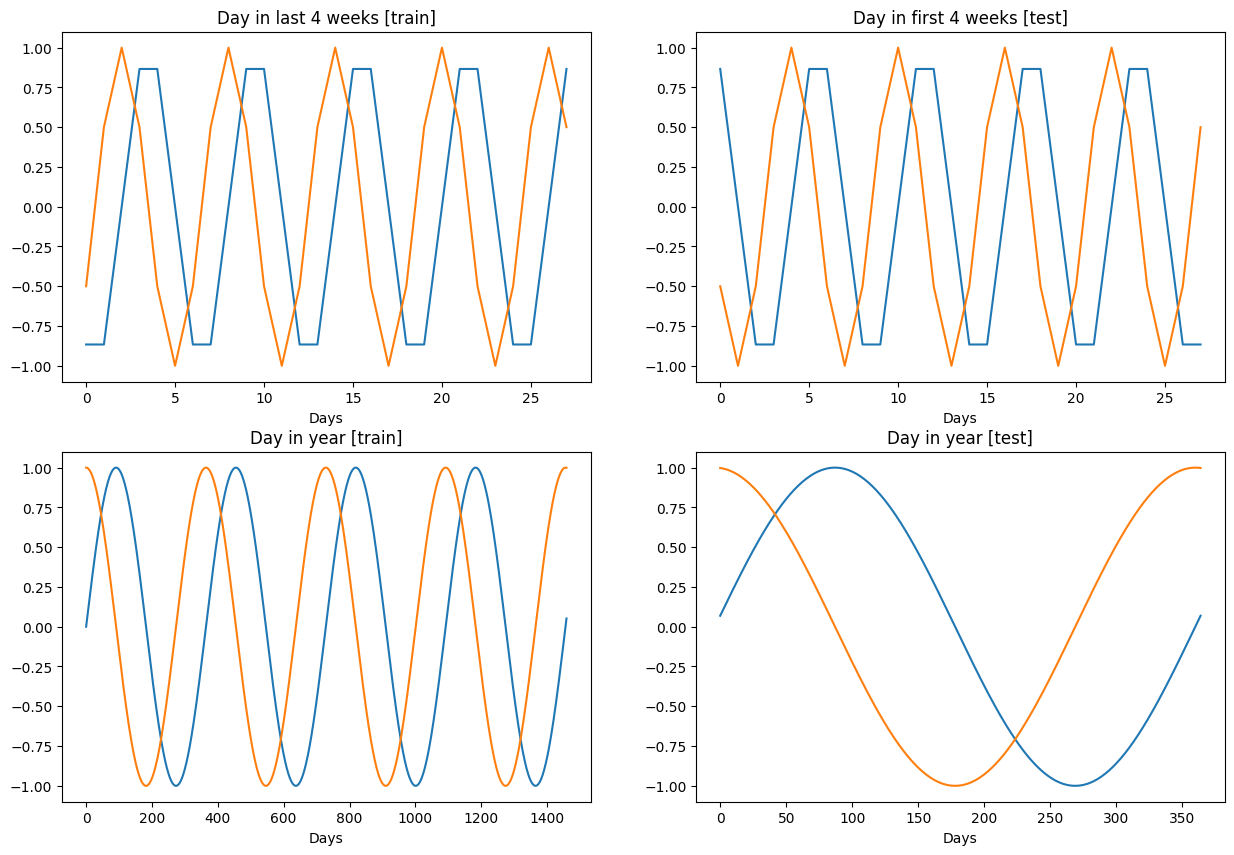

In [187]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df['week_sin'])[::ROWS_PER_DAY][-28:])
axes[0][0].plot(np.array(train_df['week_cos'])[::ROWS_PER_DAY][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df['week_sin'])[::ROWS_PER_DAY][:28])
axes[0][1].plot(np.array(test_df['week_cos'])[::ROWS_PER_DAY][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df['year_sin'])[::ROWS_PER_DAY])
axes[1][0].plot(np.array(train_df['year_cos'])[::ROWS_PER_DAY])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df['year_sin'])[::ROWS_PER_DAY])
axes[1][1].plot(np.array(test_df['year_cos'])[::ROWS_PER_DAY])

## 💡 Idea 1
- Data distribution in years before 2020 is different to 2020. 
- Assuming that the year 2021 will be similar to 2020 as COVID was still active let's focus on the year 2020 as training data.
- In the year 2020 we saw that the country does <b> not </b> have any impact on the sales. What does matter is the store and the product.
- We also learned from EDA that the daily per product sales are reasonably identical across the two shops. Therefore, by multiplying the Rama store sales by `2.88` we obatin the Mart store sales.
- To conclude let's
    - use data for later than 01.01.2020
    - average the sales over the country
    - multiply Rama store by `2.885` & average per product = normalise both and average per product.

### Use data later than 01.01.2020 for training

In [188]:
train_df_prep = train_df[train_df["date"] >= pd.Timestamp("2020-01-01")]
test_df_prep = test_df.copy(deep = True)

### Average sales over country

In [189]:
train_df_prep = train_df_prep.groupby(['date','store','product']).agg({
    'num_sold': 'mean',
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

test_df_prep = test_df_prep.groupby(['date','store','product']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

In [190]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [191]:
test_df_prep.head()

,date,store,product,year_cos,year_sin,week_sin,week_cos
0,2021-01-01,KaggleMart,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5
1,2021-01-01,KaggleMart,Kaggle Getting Started,0.997617,0.068991,0.866025,-0.5
2,2021-01-01,KaggleMart,Kaggle Recipe Book,0.997617,0.068991,0.866025,-0.5
3,2021-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,0.997617,0.068991,0.866025,-0.5
4,2021-01-01,KaggleRama,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5


#### Plot to make sure the week cycles align

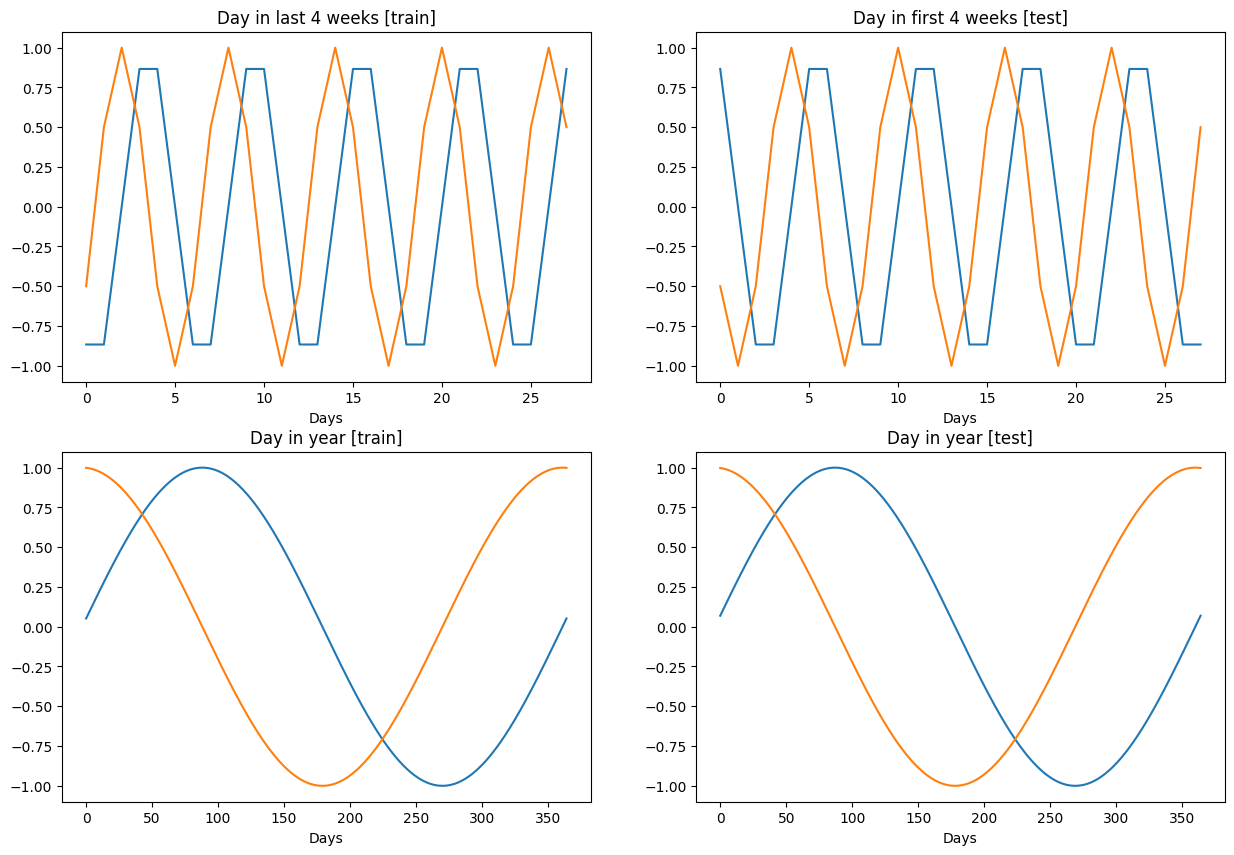

In [193]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df_prep['week_sin'])[::8][-28:])
axes[0][0].plot(np.array(train_df_prep['week_cos'])[::8][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df_prep['week_sin'])[::8][:28])
axes[0][1].plot(np.array(test_df_prep['week_cos'])[::8][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df_prep['year_sin'])[::8])
axes[1][0].plot(np.array(train_df_prep['year_cos'])[::8])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df_prep['year_sin'])[::8])
axes[1][1].plot(np.array(test_df_prep['year_cos'])[::8])

### Normalise and take mean

In [244]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [310]:
avg_store_product = train_df_prep.pivot(index='date', columns=['store', 'product'], values=['num_sold'])
print(f"Mean: {avg_store_product.mean()}")
print(f"Std: {avg_store_product.std()}")
avg_store_product = (avg_store_product - avg_store_product.mean()) / avg_store_product.std()
avg_store_product = avg_store_product.droplevel(level=0, axis=1).droplevel(level=0, axis=1)
avg_store_product.head()

num_sold                         \
store                      KaggleMart                          
product    Kaggle Advanced Techniques Kaggle Getting Started   
date                                                           
2020-01-01                   0.280218               0.388970   
2020-01-02                   1.600707               1.236696   
2020-01-03                   1.525767               1.070587   
2020-01-04                   1.763507               1.314022   
2020-01-05                   2.127868               1.955545   

                                                                \
store                                                            
product    Kaggle Recipe Book Kaggle for Kids: One Smart Goose   
date                                                             
2020-01-01           1.151761                         0.282702   
2020-01-02           2.047709                         1.897908   
2020-01-03           1.639429                         1.337030   
2020-01-04           2.187583                         1.812091   
2020-01-05           2.697933                         2.743823   

                                                              \
store                      KaggleRama                          
product    Kaggle Advanced Techniques Kaggle Getting Started   
date                                                           
2020-01-01                   0.246626               0.263659   
2020-01-02                   1.075456               1.120164   
2020-01-03                   1.090526               1.031282   
2020-01-04                   1.700846               1.386812   
2020-01-05                   2.250888               1.596898   

                                                                
store                                                           
product    Kaggle Recipe Book Kaggle for Kids: One Smart Goose  
date                                                            
2020-01-01           1.073935                         0.306637  
2020-01-02           1.928963                         1.684308  
2020-01-03           1.720687                         1.702200  
2020-01-04           2.060506                         2.399981  
2020-01-05           2.805915                         2.265792

In [312]:
train_df_prep = train_df_prep.groupby(['date']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first'
}).reset_index()

In [316]:
train_df_prep.set_index("date", inplace=True)

In [319]:
train_df_prep["Kaggle Advanced Techniques"] = avg_store_product["Kaggle Advanced Techniques"].mean(axis=1)
train_df_prep["Kaggle Getting Started"] = avg_store_product["Kaggle Getting Started"].mean(axis=1)
train_df_prep["Kaggle Recipe Book"] = avg_store_product["Kaggle Recipe Book"].mean(axis=1)
train_df_prep["Kaggle for Kids: One Smart Goose"] = avg_store_product["Kaggle for Kids: One Smart Goose"].mean(axis=1)
train_df_prep.head()

,year_cos,year_sin,week_sin,week_cos,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,,,,,
2020-01-01,0.998659,0.051761,1.832554e-13,-1.0,0.263422,0.326315,1.112848,0.294669
2020-01-02,0.997617,0.068991,-8.660254e-01,-0.5,1.338081,1.178430,1.988336,1.791108
2020-01-03,0.996278,0.086200,-8.660254e-01,0.5,1.308146,1.050934,1.680058,1.519615
2020-01-04,0.994642,0.103384,-8.034921e-14,1.0,1.732176,1.350417,2.124044,2.106036
2020-01-05,0.992709,0.120537,8.660254e-01,0.5,2.189378,1.776221,2.751924,2.504807


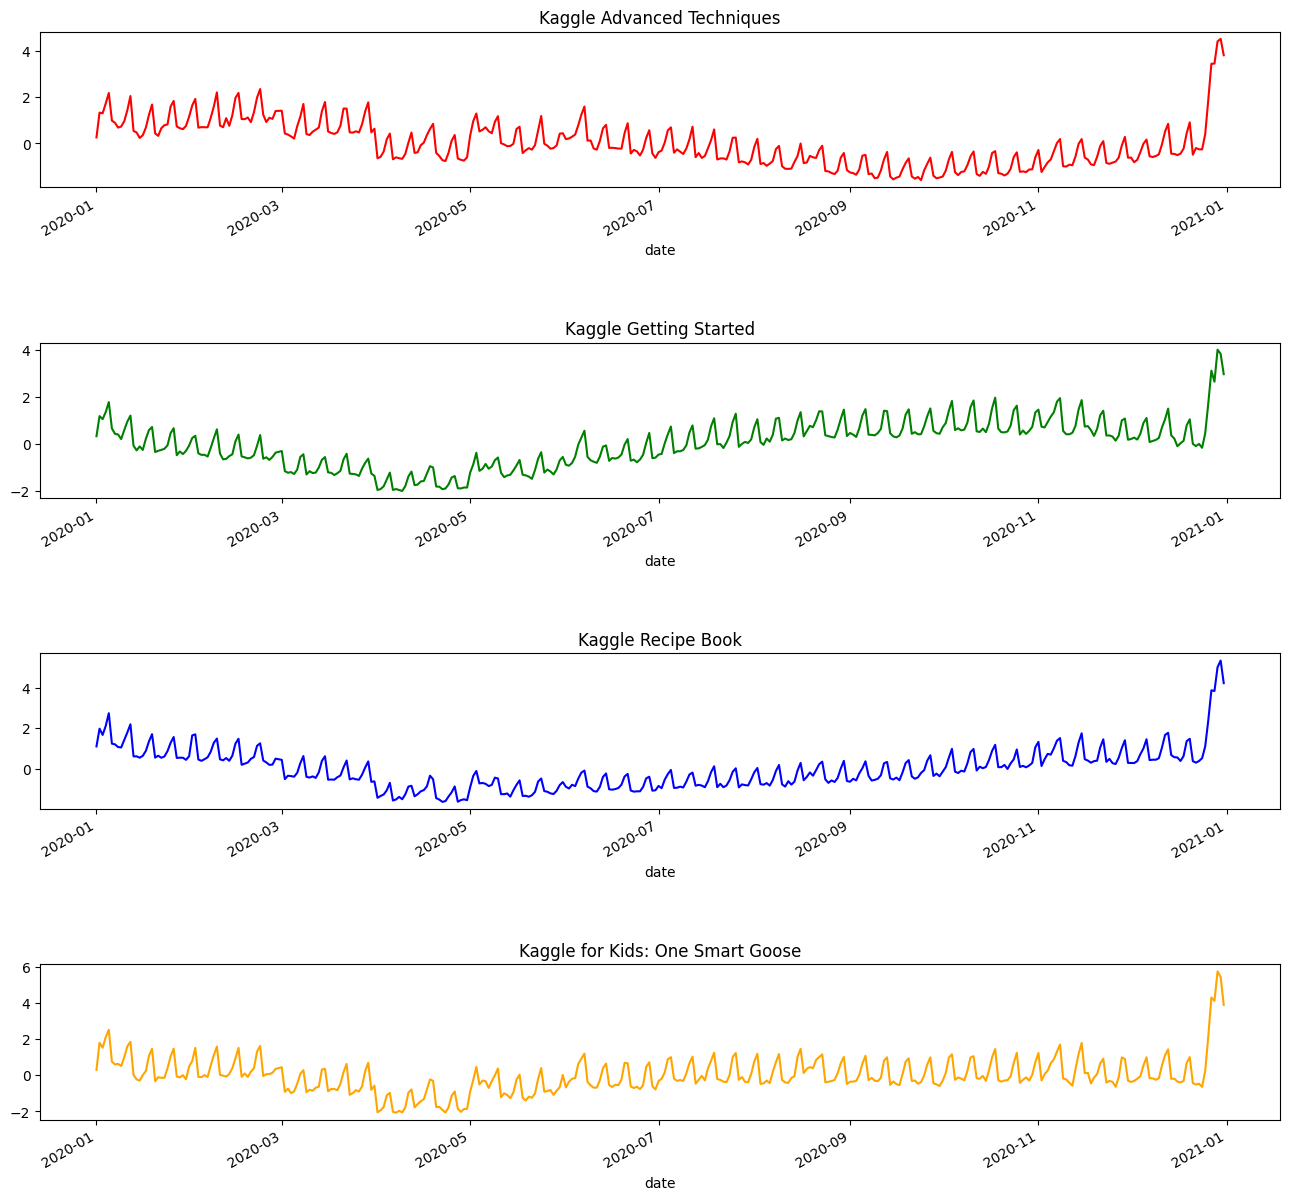

In [333]:

# Configure subplot 
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,16), )
axes[0].set_title("Kaggle Advanced Techniques")
axes[0].set_xlabel("Dates")
train_df_prep["Kaggle Advanced Techniques"].plot(label="Kaggle Advanced Techniques", c = 'r', ax = axes[0])
axes[1].set_title("Kaggle Getting Started")
axes[1].set_xlabel("Dates")
train_df_prep["Kaggle Getting Started"].plot(label="Kaggle Getting Started", c = 'g', ax = axes[1])
axes[2].set_title("Kaggle Recipe Book")
axes[2].set_xlabel("Dates")
train_df_prep["Kaggle Recipe Book"].plot(label="Kaggle Recipe Book", c = 'b', ax = axes[2])
axes[3].set_title("Kaggle for Kids: One Smart Goose")
axes[3].set_xlabel("Dates")
train_df_prep["Kaggle for Kids: One Smart Goose"].plot(label="Kaggle for Kids: One Smart Goose", c = 'orange', ax = axes[3])
fig.subplots_adjust(hspace=1)

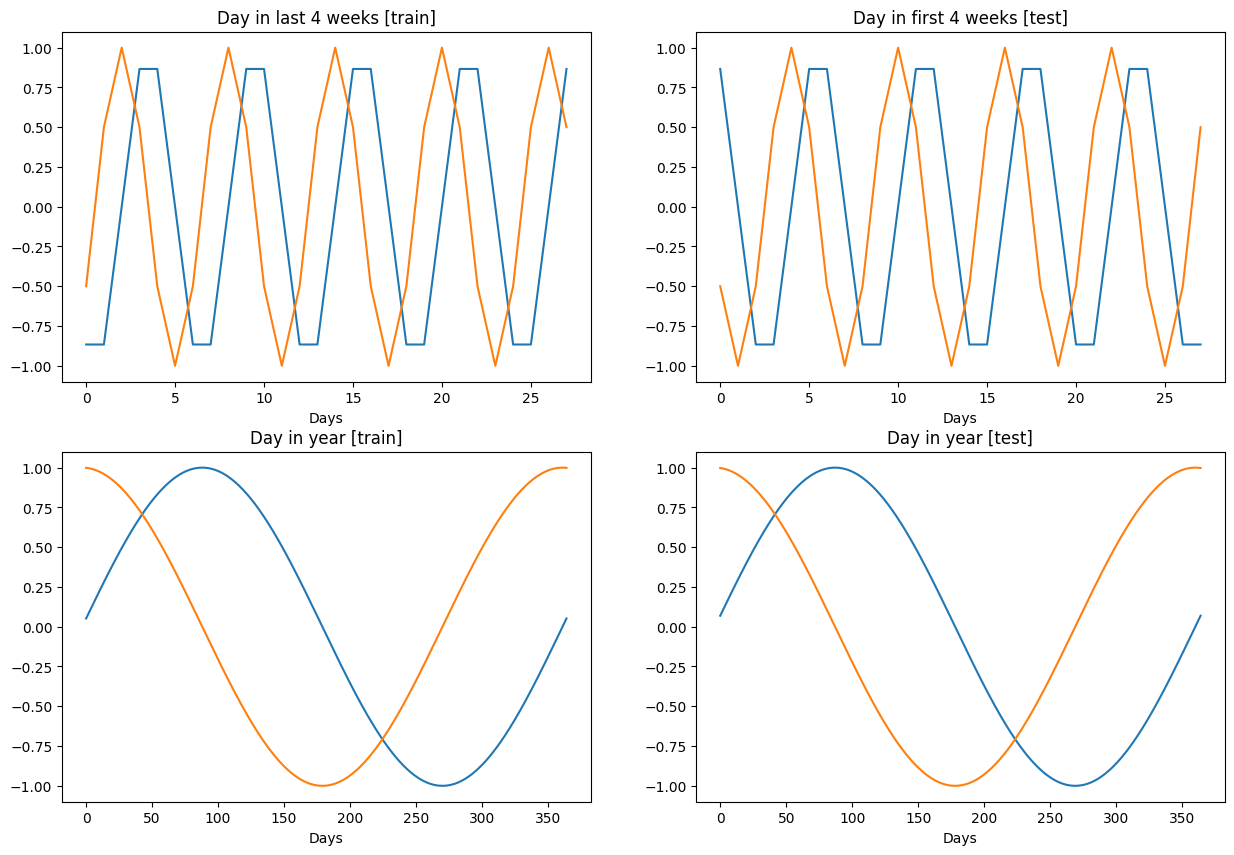

In [334]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df_prep['week_sin'])[::1][-28:])
axes[0][0].plot(np.array(train_df_prep['week_cos'])[::1][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df_prep['week_sin'])[::8][:28])
axes[0][1].plot(np.array(test_df_prep['week_cos'])[::8][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df_prep['year_sin'])[::1])
axes[1][0].plot(np.array(train_df_prep['year_cos'])[::1])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df_prep['year_sin'])[::8])
axes[1][1].plot(np.array(test_df_prep['year_cos'])[::8])

In [337]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        #self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [338]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,label_columns=['Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'])

In [339]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose']

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window